# HW Tool

## 1. `shap.plots.beeswarm` нормального человека (6 баллов)

Как вы могли видеть, у встроенного beeswarm plot`а есть несколько недостатков:
- нет информации о том, какие именно значения категориальных признаков в какую сторону толкают предсказания модели
- иногда серые точки (пропущенные значения) прячутся за точками другого цвета -> их не видно (см. rooms_num на графике с семинара)
- иногда раскраска бывает некорректной (потому что она раскрашивает по абсолютным значениям)

Вам предлагается реализовать свою версию shap.plots.beeswarm, которая исправляет эти недостатки.


Итак, требуется написать функцию, которая принимает на вход shap_values и все необходимое и строит по этим данным beeswarm plot
    без вышеперечисленных недостатков, а именно:
- теперь все уникальные значения кат. фич становятся как бы отдельными фичами, по ним видны shap_values (см. пример)
    - чтобы не захламлять ваш график редковстречающимися категориями, принимайте на вход параметр, чтобы контролировать это
    - такие фичи должны быть покрашены в особый цвет, чтобы отличаться от числовых
- точки, отвечающие за наны, должны быть хорошо видны на фоне остальных и не перекрывать их
- раскраска должна адекватно красить ваши точки
    - можно выкидывать выбросы перед покраской
    - можно логарифмировать значения
    - можно красить по квантилям, а не по абсолютным значениям
    - лучше всего красятся равномерное и нормальное распределение

**Обязательно:**
- docstring
- комменты к непонятным кускам кода - что там происходит
- принимайте на вход кол-во фич, которые вы отображаете на графике
- принимайте на вход размер фигуры
- нарисуйте вертикальную линию, обозначающую 0
- сортируйте признаки по среднему модулю shap_values
- используйте stripplot (или аналоги) с jitter`ом, а не swarmplot
- принимайте на вход кол-во точек которое будете отрисовывать (500-3000 = норм)
    - если для какого-то значения кат фичи точек меньше, чем вы задали, рисуйте сколько есть

**!**
Если на вход подана слишком большая выборка, вы можете под капотом сэмплить из нее какое-то адекватное кол-во точек и отрисовывать их.
Однако, раскраску и контроль за отрисовкой категорий лучше базировать на всей выборке, поданной на вход.


Ниже приведен пример. Не меняйте код, предшествующий примеру. Вы не обязаны повторять пример точь-в-точь, это ориентир. Не удаляйте пример.

Удачи!

In [1]:
import numpy as np, pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

import warnings
from pandas.errors import PerformanceWarning

warnings.simplefilter('ignore', PerformanceWarning)


df = pd.read_parquet('train_sber.parquet')
features = df.columns.drop(['timestamp', 'result_price', 'result_price_bin'])

model = lgb.Booster(model_file='model.lgb')
shap_values = model.predict(df[features], pred_contrib=True)
            
'''
Учтите, что если вы считаете shap_values через LightGBM,
    shap_values - np.array of shape (N, F + 1), где последний столбец - константа = среднее предсказание для всех объектов
'''
print('features shape:', features.shape, 'shap_values shape:', shap_values.shape)
df.head(3)

features shape: (36,) shap_values shape: (27232, 37)


,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,cafe_count,fitness_center_distance,floor,district_population,...,public_transport_station_distance,sadovoe_km,base_school_distance,sport_count,state,district_name,timestamp,malls_count,railway_station_distance,result_price_bin
0,6407578.100,1.422391,3.830951,NaN,13.675657,24.292406,152,0.485841,4.0,86206,...,3.299822,13.100618,0.177975,52,NaN,Bibirevo,2011-08-20,52,14.231961,False
1,9589336.912,2.887377,3.103996,NaN,8.132640,5.706113,177,0.668364,3.0,76284,...,0.783160,6.444333,0.273345,66,NaN,Nagatinskij Zaton,2011-08-23,40,9.242586,False
2,4808269.831,0.647250,2.927487,NaN,8.054252,6.710302,122,0.733101,2.0,101982,...,3.945073,6.963403,0.158072,67,NaN,Tekstil'shhiki,2011-08-27,35,9.540544,False


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder

def my_beeswarm(shap_values, feature_values, feature_names=None, max_display=20, figsize=(10, 6),
             title="SHAP Beeswarm Plot", fig_ax=None, min_category_frac=0.05,
             log_scale=False, quantile_coloring=False, sample_points=None):
    """
    Create an enhanced SHAP beeswarm plot with support for both numeric and categorical features.
    The plot visualizes SHAP values, showing the impact of each feature on the model’s predictions.

    Parameters
    ----------
    shap_values : numpy.ndarray, shape (n_samples, n_features)
        SHAP values corresponding to each input sample and feature.

    feature_values : array-like or pandas.DataFrame, shape (n_samples, n_features)
        The original feature values corresponding to the SHAP values.

    feature_names : list or array-like of str, optional
        Names of the features to display.

    max_display : int, default=20
        The maximum number of features to show in the plot.

    figsize : tuple, default=(10, 6)
        The size of the output matplotlib figure.

    title : str, default="SHAP Beeswarm Plot"
        Title of the plot.

    fig_ax : tuple (matplotlib.figure.Figure, matplotlib.axes.Axes), optional
        Optionally pass an existing figure and axes to plot into.

    min_category_frac : float, default=0.05
        For categorical features, categories must appear in at least this fraction of samples to be visualized.

    log_scale : bool, default=False
        If True, numeric feature values are transformed with `log1p` before color mapping.

    quantile_coloring : bool, default=False
        If True, numeric feature values are colored based on quantiles.

    sample_points : int or None, default=None
        If an integer is provided, a random subsample of that many data points is used for plotting.
    """
    
    # Step 1: Initialize plot if no existing axes are provided
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = fig_ax

    # Step 2: Ensure matching dimensions between SHAP values and feature values
    if shap_values.shape[1] - 1 == feature_values.shape[1]:
        shap_values = shap_values[:, :-1]

    n_samples, n_features = shap_values.shape  # Get the number of samples and features

    # Step 3: Set feature names if not provided
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(n_features)]
    else:
        feature_names = np.array(feature_names)

    # Step 4: Convert feature values to a DataFrame if they are not already
    if not isinstance(feature_values, pd.DataFrame):
        feature_values = pd.DataFrame(feature_values, columns=feature_names)

    # Step 5: Subsample if needed for large datasets
    if sample_points is not None and sample_points < len(feature_values):
        sample_idx = np.random.choice(len(feature_values), size=sample_points, replace=False)
        shap_values = shap_values[sample_idx]
        feature_values = feature_values.iloc[sample_idx]

    # Step 6: Initialize lists for extended features (one-hot encoding for categorical variables)
    extended_shap = []
    extended_feature_names = []
    extended_feat_values = []

    # Step 7: Set up color maps for categorical and numeric data
    category_color_map = colormaps["Set3"]
    numeric_color_map = colormaps["coolwarm"]

    # Dictionary to store color mappings for categorical variables
    categorical_color_legend = {}

    # Step 8: Loop through all features to separate numeric and categorical data
    for i in range(n_features):
        feat_name = feature_names[i]
        shap_col = shap_values[:, i]  # Get the SHAP values for this feature
        feat_col = feature_values.iloc[:, i]  # Get the feature values
        

        # If the feature is numeric, apply log scaling if requested
        if pd.api.types.is_numeric_dtype(feat_col):
            if log_scale:
                feat_col = np.log1p(feat_col.replace([np.inf, -np.inf], np.nan))  # Log scale transformation (1p so 0-approaching values are handled correctly)
            extended_shap.append(shap_col)
            extended_feat_values.append(feat_col)
            extended_feature_names.append(feat_name)
        else:
            # For categorical features, expand them into one-hot encoding
            val_counts = feat_col.value_counts(normalize=True)  
            frequent_vals = val_counts[val_counts >= min_category_frac].index  # Filter by minimum category fraction
            for j, val in enumerate(frequent_vals):
                mask = feat_col == val  # Create a mask for the current category
                shap_ohe = shap_col.copy()
                shap_ohe[~mask] = 0  # Set SHAP values to 0 where the feature is not equal to the category
                name = f"{feat_name} = {val}"
                extended_shap.append(shap_ohe)  # Add the SHAP values for the category
                extended_feat_values.append(mask.astype(int))  # Store the binary (one-hot) values
                extended_feature_names.append(name)
                # Assign a color to the category from the color map
                color = category_color_map(len(categorical_color_legend) % 12)
                categorical_color_legend[name] = color

    # Step 9: Convert extended feature values and names into arrays
    extended_shap = np.vstack(extended_shap).T
    extended_feat_values = pd.DataFrame(np.vstack(extended_feat_values).T, columns=extended_feature_names)
    extended_feature_names = np.array(extended_feature_names)

    # Step 10: Sort features by their mean absolute SHAP value (importance)
    mean_abs_shap = np.abs(extended_shap).mean(axis=0)
    sorted_idx = np.argsort(mean_abs_shap)[::-1][:max_display]
    top_features = extended_feature_names[sorted_idx]

    # Step 11: Initialize plot variables
    colorbar_drawn = False

    # Step 12: Loop through the sorted features to plot them
    for i, idx in enumerate(sorted_idx):
        shap_vals = extended_shap[:, idx]
        feat_vals = extended_feat_values.iloc[:, idx]
        name = extended_feature_names[idx]

        isnan = pd.isna(feat_vals)  # Identify missing values (NaN)
        notnan = ~isnan  # Get non-missing values

        y_full = np.random.normal(loc=i, scale=0.1, size=len(shap_vals))  # Add jitter to y values for visual separation
        y_nan = np.random.normal(loc=i, scale=0.01, size=len(shap_vals))

        # Step 13: Plot missing values as black points
        if isnan.any():
            ax.scatter(
                shap_vals[isnan],
                y_nan[isnan],
                color='black',
                alpha=0.7,
                s=10,
                edgecolor='none',
                zorder=10,
                label='Missing (NaN)' if i == 0 else None
            )

        # Step 14: Plot categorical feature values
        if name in categorical_color_legend:
            color = categorical_color_legend[name]
            ax.scatter(
                shap_vals[notnan],
                y_full[notnan],
                color=['gray'] * sum(notnan),
                alpha=0.7,
                s=10,
                edgecolor='none'
            )
        else:
            # Step 15: Plot numeric feature values with coloring based on quantiles or raw values
            values = feat_vals[notnan]

            if quantile_coloring:
                ranks = values.rank(method="average") / len(values)  # Normalize by quantiles
                norm = Normalize(0, 1)
                colors = numeric_color_map(norm(ranks))
            else:
                # Use percentile-based normalization
                norm = Normalize(np.nanpercentile(values, 1), np.nanpercentile(values, 99))
                colors = numeric_color_map(norm(values))
                

            ax.scatter(
                shap_vals[notnan],
                y_full[notnan],
                color=colors,
                alpha=0.7,
                s=10,
                edgecolor='none'
            )

            # Step 16: Draw colorbar for numeric values (if not already drawn)
            if not colorbar_drawn:
                sm = plt.cm.ScalarMappable(cmap=numeric_color_map, norm=norm)
                sm.set_array([])
                cbar = fig.colorbar(sm, ax=ax, label="Numeric feature value", orientation="horizontal", pad=0.15)
                colorbar_drawn = True

    # Step 17: Set axis labels and title
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features)
    ax.set_xlabel("SHAP value")
    ax.set_title(title)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Step 20: Adjust layout and return the axis object
    plt.tight_layout()
    return ax

<Axes: title={'center': 'Shap Beeswarm log_scale + quantile coloring + subsampling points'}, xlabel='SHAP value'>

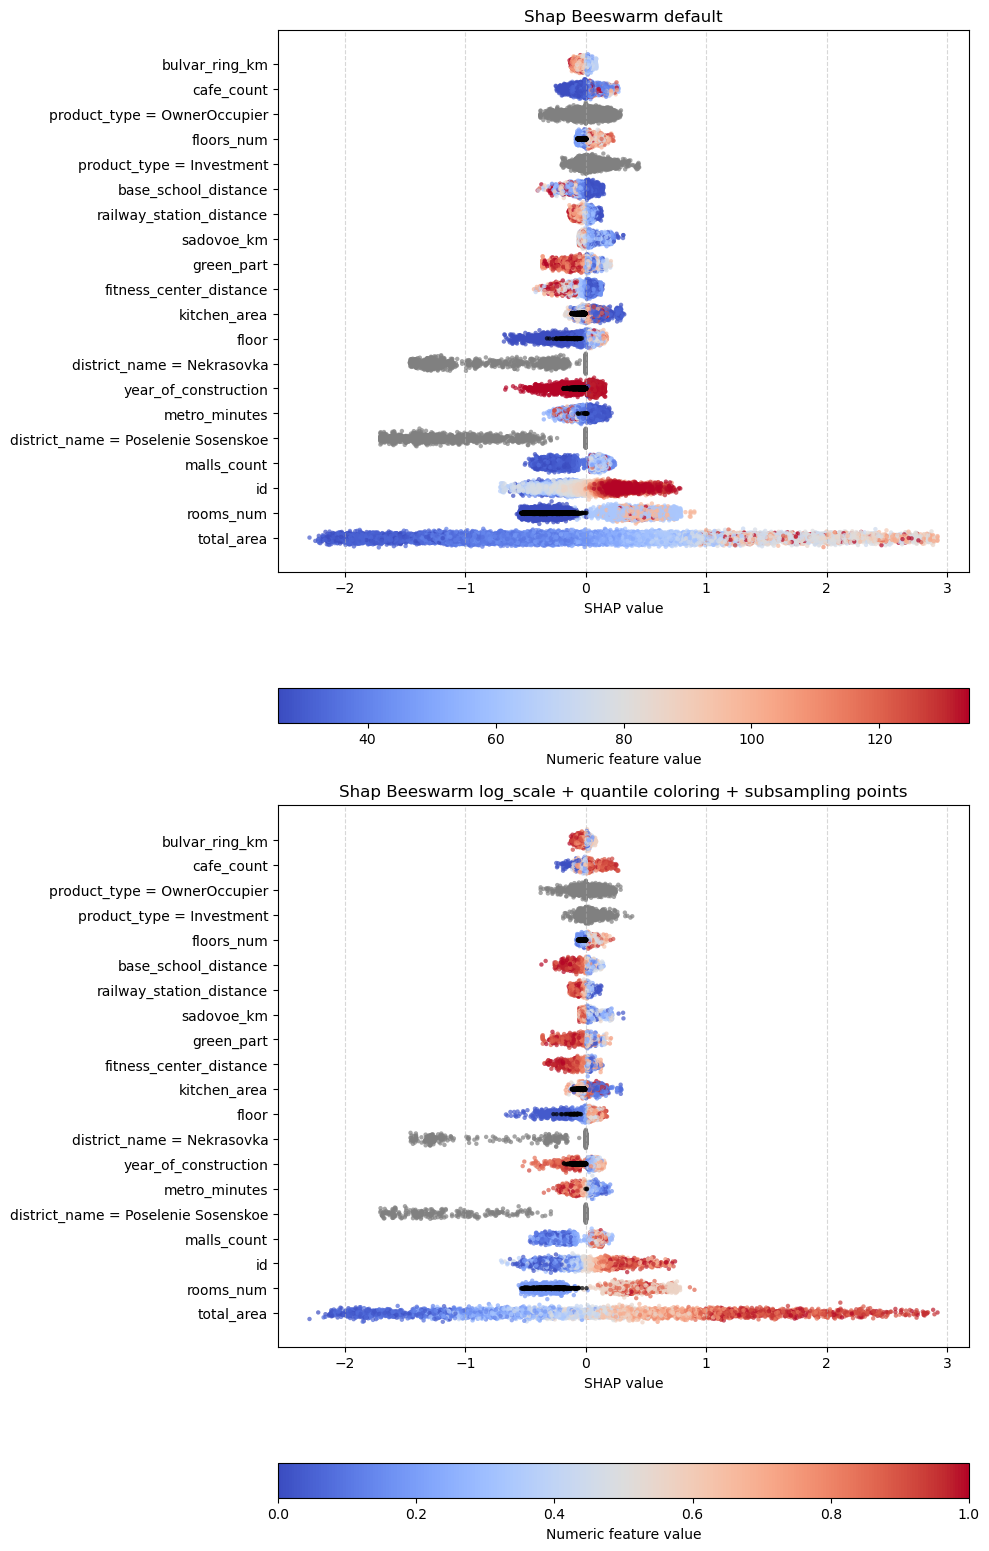

In [34]:
fig, ax = plt.subplots(2, figsize = (10, 16))

my_beeswarm(shap_values,
         df[features],
         features, 
         fig_ax=(fig, ax[0]),
         max_display=20,
         title = "Shap Beeswarm default"
)

my_beeswarm(
    shap_values,
    df[features],
    feature_names=features,
    max_display=20,
    log_scale=True,
    quantile_coloring=True,
    sample_points=5000, 
    fig_ax=(fig, ax[1]),
    title = "Shap Beeswarm log_scale + quantile coloring + subsampling points"
)

In [ ]:
def my_beeswarm(model: lgb.Booster, df: pd.DataFrame, features: list[str], 
                cat_feature_threshold: float, shap_values: np.ndarray, 
                top_k: int = 10, figsize: tuple[int, int] = (10, 6), 
                dots: int = 1000) -> plt.Figure:
    """
    Улучшенная версия beeswarm plot для визуализации SHAP значений.
    
    Параметры:
    ----------
    model : lgb.Booster
        Модель LightGBM
    df : pd.DataFrame
        Исходные данные
    features : list[str]
        Список признаков
    cat_feature_threshold : float
        Порог для отображения категориальных значений (минимальная частота)
    shap_values : np.ndarray
        SHAP значения (N x F+1), последний столбец - константа
    top_k : int, optional
        Количество топовых признаков для отображения (по умолчанию 10)
    figsize : tuple[int, int], optional
        Размер фигуры (по умолчанию (10, 6))
    dots : int, optional
        Количество точек для отображения (по умолчанию 1000)
        
    Возвращает:
    -----------
    plt.Figure
        Объект matplotlib Figure с визуализацией
    """
    
    # 1. Предобработка SHAP значений
    shap_values = shap_values[:, :-1]
    df_shap = pd.DataFrame(shap_values, columns=features)
    
    # 2. Обработка категориальных признаков
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    for cat in cat_cols:
        if cat not in features:
            continue
            
        value_counts = df[cat].value_counts(normalize=True)
        filtered_values = value_counts[value_counts >= cat_feature_threshold].index

        new_cols = {
            f"{cat} == {value}": (df[cat] == value).astype(int)
            for value in filtered_values
        }
        
        # Создаем новые бинарные признаки
        new_df = pd.DataFrame(new_cols)
        df = pd.concat([df, new_df], axis=1)
        
        # Для SHAP значений - копируем оригинальные значения только для соответствующих категорий
        for value in filtered_values:
            mask = (df[cat] == value)
            df_shap[f"{cat} == {value}"] = np.where(mask, df_shap[cat], 0)
        
        df.drop(columns=[cat], inplace=True)
        df_shap.drop(columns=[cat], inplace=True)
    
    # 3. Выбор топ признаков
    mean_shap_value = df_shap.abs().mean().sort_values(ascending=False)
    top_features = mean_shap_value.head(top_k).index.tolist()
    
    # 4. Подготовка данных для визуализации
    if len(df) > dots:
        index_sample = np.random.choice(df.index, size=dots, replace=False)
        df_sampled = df.loc[index_sample]
        df_shap_sampled = df_shap.loc[index_sample]
    else:
        df_sampled = df.copy()
        df_shap_sampled = df_shap.copy()

    # 5. Создание фигуры
    fig, ax = plt.subplots(figsize=figsize)

    # 6. Построение графика для каждого признака
    for i, feature in enumerate(top_features):
        # Подготовка данных для текущего признака
        shap_data = df_shap_sampled[feature]
        feature_data = df_sampled[feature] if feature in df_sampled else None
        
        # Разделение на пропущенные и непропущенные значения
        if feature_data is not None:
            is_missing = feature_data.isna()
            missing_shap = shap_data[is_missing]
            non_missing_shap = shap_data[~is_missing]
            non_missing_values = feature_data[~is_missing]
        else:
            # Для dummy-переменных нет пропущенных значений
            is_missing = pd.Series(False, index=shap_data.index)
            non_missing_shap = shap_data
            non_missing_values = None
        
        # Визуализация непропущенных значений
        if len(non_missing_shap) > 0:
            if " == " in feature:  # Категориальный признак
                # Для категориальных - фиолетовый цвет
                sns.stripplot(
                    x=non_missing_shap.values,
                    y=[feature] * len(non_missing_shap),
                    ax=ax,
                    color='purple',
                    alpha=0.7,
                    jitter=0.3,
                    size=4,
                    linewidth=0.5
                )
            else:  # Числовой признак
                # Подготовка данных для цветового градиента
                vals = non_missing_values
                if vals.nunique() > 1:
                    # Обрезка выбросов для цветовой шкалы
                    vmin, vmax = vals.quantile([0.01, 0.99])
                    clipped_vals = vals.clip(vmin, vmax)
                    
                    # Создаем DataFrame для stripplot
                    plot_df = pd.DataFrame({
                        'shap': non_missing_shap.values,
                        'feature': [feature] * len(non_missing_shap),
                        'value': clipped_vals
                    })
                    
                    # Рисуем с цветовым градиентом
                    sns.stripplot(
                        x='shap',
                        y='feature',
                        hue='value',
                        data=plot_df,
                        ax=ax,
                        palette='coolwarm',
                        alpha=0.7,
                        jitter=0.3,
                        size=4,
                        linewidth=0.5,
                        hue_norm=(vmin, vmax)
                    )
                    
                    # Убираем легенду (она будет дублировать colorbar)
                    ax.get_legend().remove()
                else:
                    # Если все значения одинаковые - синий цвет
                    sns.stripplot(
                        x=non_missing_shap.values,
                        y=[feature] * len(non_missing_shap),
                        ax=ax,
                        color='blue',
                        alpha=0.7,
                        jitter=0.3,
                        size=4,
                        linewidth=0.5
                    )
        
        # Визуализация пропущенных значений
        if len(missing_shap) > 0:
            ax.plot(
                missing_shap.values,
                [feature]*len(missing_shap),
                'o',
                color='black',
                alpha=0.9,
                markersize=4,
                markeredgecolor='black',
                markeredgewidth=1,
                zorder = 10
            )
    
    # 7. Добавление вертикальной линии на 0
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    
    # 8. Настройка внешнего вида
    ax.set_xlabel('SHAP value', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.set_title('Custom Beeswarm Plot of SHAP Values', fontsize=14)
    
    # Добавление colorbar для числовых признаков
    if any(" == " not in f for f in top_features):
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Feature value (normalized)', rotation=270, labelpad=15)
    
    plt.tight_layout()

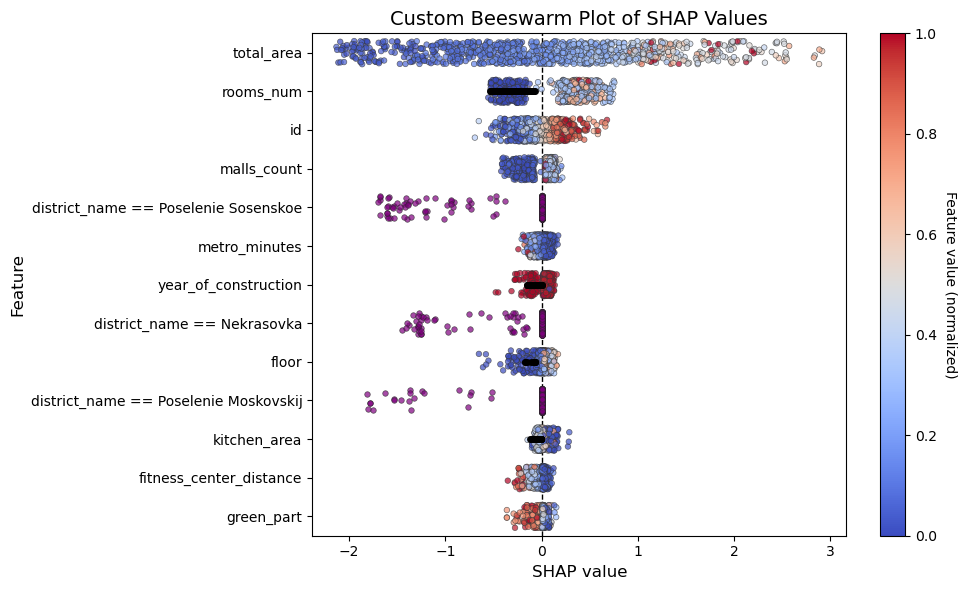

In [13]:
my_beeswarm(model, df, features, cat_feature_threshold=0.001, shap_values=shap_values, top_k=13, figsize=(10, 6), dots=1000)

Пример ниже. Не удаляйте пример!

CPU times: total: 1.61 s
Wall time: 1.61 s


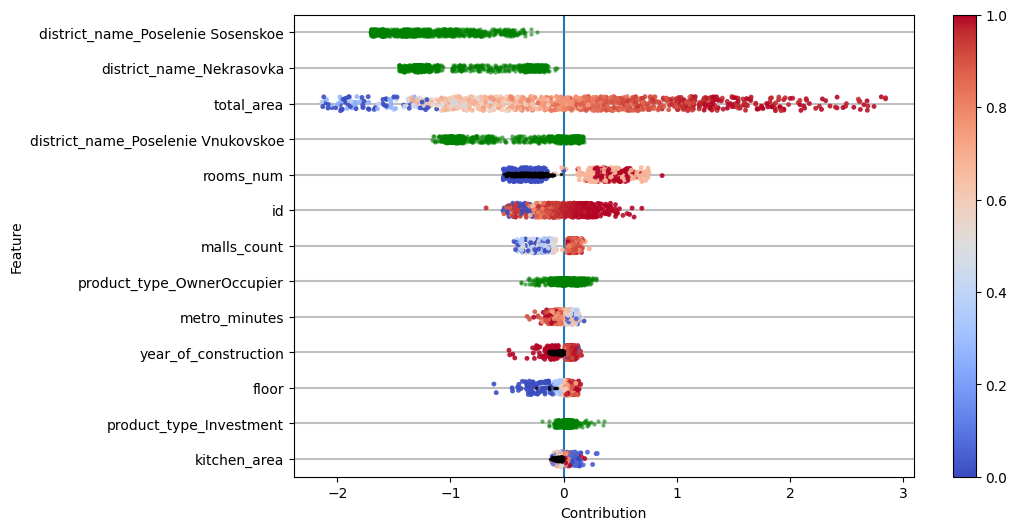

In [28]:
%%time
from utils import shap_beeswarm

shap_beeswarm(model, df, features, cat_feature_threshold=0.001, shap_values=shap_values, top_k=13, figsize=(10, 6), dots=1000)

## 2. Логирование градиентов при обучении (4 балла)

**Задача:** хотим для каждого объекта для каждого дерева получить gi - производную лосса!
Чтобы:
- нарисовать карту объект-дерево
- поизучать 2D-представления
- призадуматься...

**Как:** придумайте способ! Нужно в процессе обучения сохранять градиенты LogLoss`а объектов на каждом дереве, после чего продемонстрировать собранные градиенты с помощью sns.clustermap. 

Ниже пример. Не удаляйте пример!

-----------------------

Если продифференцировать логлосс и упростить, то получаем, что его градиент равен разности предсказаного значения и истинного

In [23]:
def somehow_get_grads(model, tr, features=None):
    num_trees = model.num_trees()
    n_samples = len(tr)
    y_true = tr.result_price_bin.values

    if features is None:
        features = tr.columns.drop(['timestamp', 'result_price', 'result_price_bin']).tolist()
    
    # Явное преобразование категориальных признаков
    X = tr[features].copy()
    for col in X.select_dtypes(include=['object', 'category']).columns:
        X[col] = X[col].astype('category').cat.codes
    
    grads = np.zeros((num_trees, n_samples))
    
    all_preds = np.array([
        model.predict(X.values, num_iteration=i+1, raw_score=True)
        for i in range(num_trees)
    ])
    
    y_pred_probs = 1.0 / (1.0 + np.exp(-all_preds))
    grads = y_pred_probs - y_true
    
    return grads

In [24]:
def get_split(df, val_size=0.33, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Фиксируем сид для воспроизводимости
    
    train_idx = np.random.choice(df.index, size=int(df.shape[0]*(1-val_size)), replace=False)
    val_idx = np.setdiff1d(df.index, train_idx)
    return df.loc[train_idx].reset_index(drop=True), df.loc[val_idx].reset_index(drop=True)

# Пример использования с seed:
tr, val = get_split(df, val_size=0.33, seed=32)  # 42 — произвольное фиксированное число
lgb_tr = lgb.Dataset(tr[features], tr.result_price_bin)

grads = somehow_get_grads(model, tr)
grads.shape

(300, 18245)

c:\Users\Admin\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


CPU times: total: 24.5 s
Wall time: 24.8 s


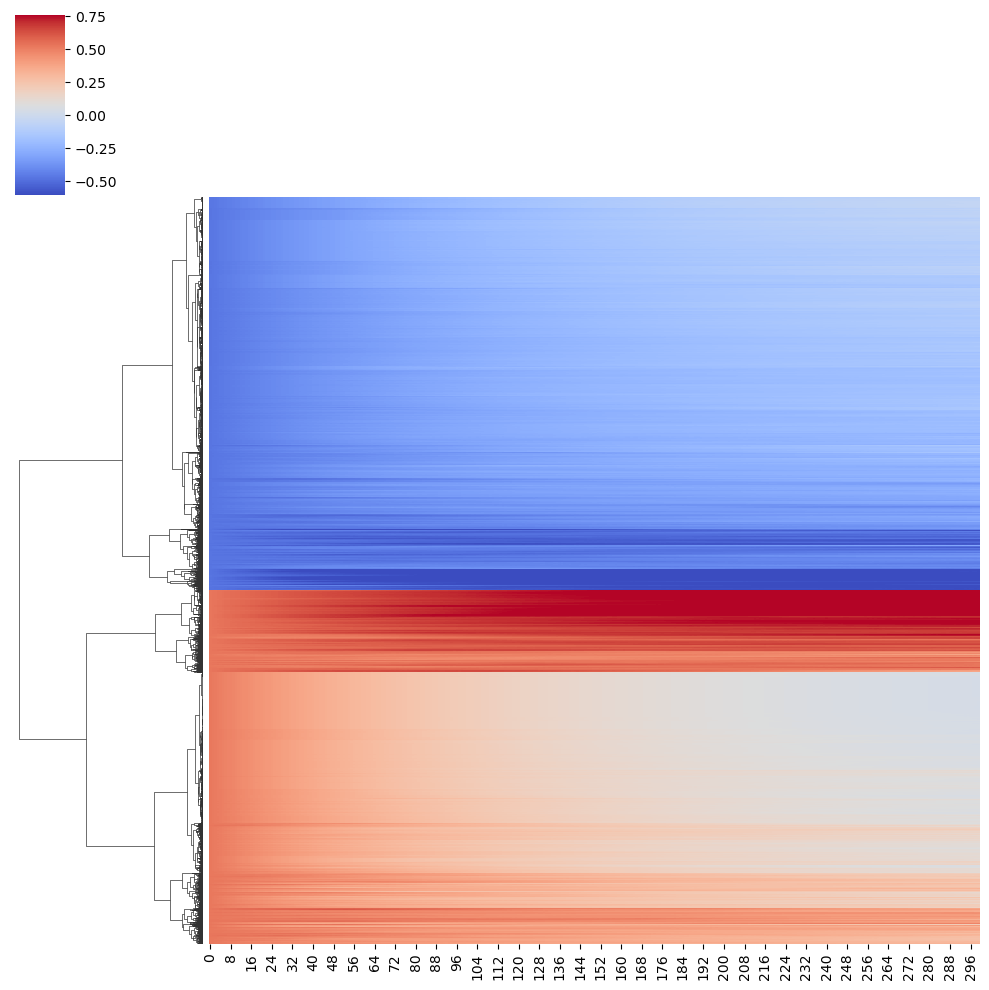

In [25]:
%%time
import seaborn as sns

# предварительно установите fastcluster: pip install fastcluster, иначе считаться будет долго
sns.clustermap(grads.T, col_cluster=False, robust=True, yticklabels=False, cmap='coolwarm')

Пример. Не удаляйте пример!

In [104]:
def get_split(df, val_size=0.33):
    train_idx = np.random.choice(df.index, size=int(df.shape[0]*(1-val_size)), replace=False)
    val_idx = np.setdiff1d(df.index, train_idx)
    return df.loc[train_idx].reset_index(drop=True), df.loc[val_idx].reset_index(drop=True)

tr, val = get_split(df, val_size=0.23)
lgb_tr = lgb.Dataset(tr[features], tr.result_price_bin)

grads = somehow_get_grads()
grads.shape

(100, 20968)

CPU times: total: 1min 17s
Wall time: 1min 17s


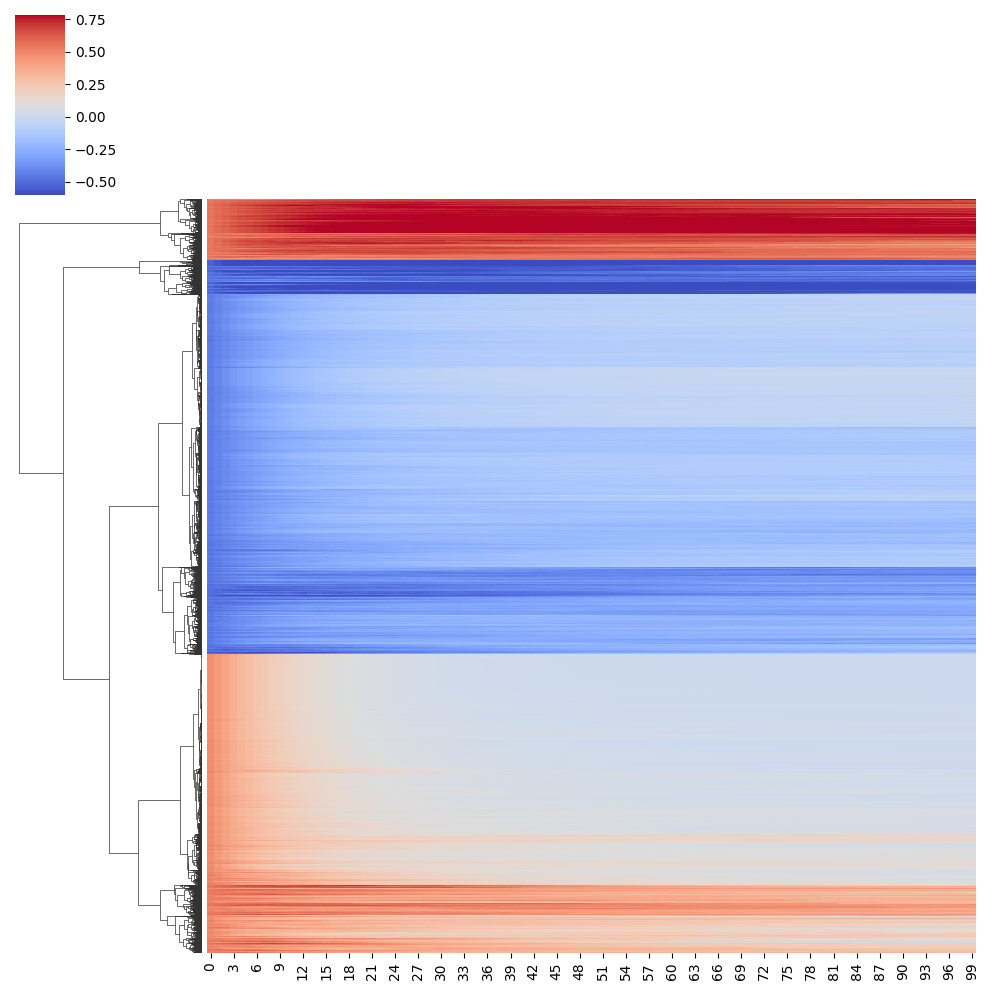

In [102]:
%%time
import seaborn as sns

# предварительно установите fastcluster: pip install fastcluster, иначе считаться будет долго
sns.clustermap(grads.T, col_cluster=False, robust=True, yticklabels=False, cmap='coolwarm')

## 3. Автоматическое создание весов для бинарной классификации (5 баллов)

В этом блоке ваша цель - написать функцию, которая генерирует вектор весов для объектов обучающей выборки следующим образом:
1) на вход подается таргет-колонка и произвольная колонка
2) если колонка числовая, бьем ее на бины (кол-во бинов `bins` принимаем на вход. берем небольшое, около 7-13)
    - если в колонке < `bins` уникальных, бить не надо 
3) если колонка категориальная, тоже бьем ее на бины
    - если уникальных значений <= `bins`, то за бины считаем уникальные значения категории
    - если уникальных значений >  `bins`, то выбираем `bins` - 1 самых популярных категорий у объектов класса 1
    - не попавшие в топ самых популярных категории запихиваем в бин 'other'

4) проходимся по всем бинам, присваивая всем объектам класса 1, попавшим в бин, вес n_0_in_bin / n_1_in_bin,
       если объектов класса 0, попавших в этот бин, достаточное кол-во (принимайте на вход, зависит от задачи)

5) всем объектам класса 0 присваиваем вес, равный единице

Такая схема на практике работает лучше, чем обычный `scale_pos_weight` параметр в LightGBM и его аналоги, если разумно выбирать
    вспомогательную колонку. Подумайте, как именно нужно выбирать такую колонку. Ответ писать не обязательно, но можно :)

**Обязательно:**
Найдите способ продемонстрировать визуализацией, что ваша функция работает корректно!

In [36]:
def make_weights(target, feature, bins=10, min_n0=10):
    weights = np.ones(len(target), dtype=float)

    is_numeric = pd.api.types.is_numeric_dtype(feature)
    unique_values = feature.nunique()

    if is_numeric:
        if unique_values < bins:
            binned = feature
        else:
            binned = pd.cut(feature, bins = bins, duplicates='drop')
    else:
        if unique_values <= bins:
            binned = feature
        else:
            top_cat = feature[target == 1].value_counts().head(bins - 1).index
            binned = feature.where(feature.isin(top_cat), other='other')

    for bin_label in binned.unique():
        mask = (binned == bin_label)
        n0 = ((target == 0) & mask).sum()
        n1 = ((target == 1) & mask).sum()

        if n0 >= min_n0 and n1 > 0:
            weight_value = n0 / n1
            weights[(target == 1) & mask] = weight_value

    return weights, binned

def visual(binned, target, weights, min_n0):
    df = pd.DataFrame({
        'bin': binned,
        'target': target,
        'weight': weights
    })

    grouped = df.groupby('bin').apply(
        lambda x: pd.Series({
            'n0': (x['target'] == 0).sum(),
            'n1': (x['target'] == 1).sum(),
            'avg_weight': x.loc[x['target'] == 1, 'weight'].mean() if (x['target'] == 1).sum() > 0 else 1.0
        })
    ).reset_index()

    grouped = grouped[grouped['n1'] > 0]
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    melted = pd.melt(grouped, id_vars=['bin'], value_vars=['n0', 'n1'])
    sns.barplot(x='bin', y='value', hue='variable', data=melted, ax=axes[0])
    axes[0].set_title('Number of Class 0 and 1 in Each Bin')
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.barplot(x='bin', y='avg_weight', data=grouped, ax=axes[1])
    axes[1].axhline(1.0, color='r', linestyle='--', label='Default Weight (1.0)')
    axes[1].set_title('Average Weight for Class 1 in Each Bin')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_3124\3074313190.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('bin').apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_3124\3074313190.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('bin').apply(


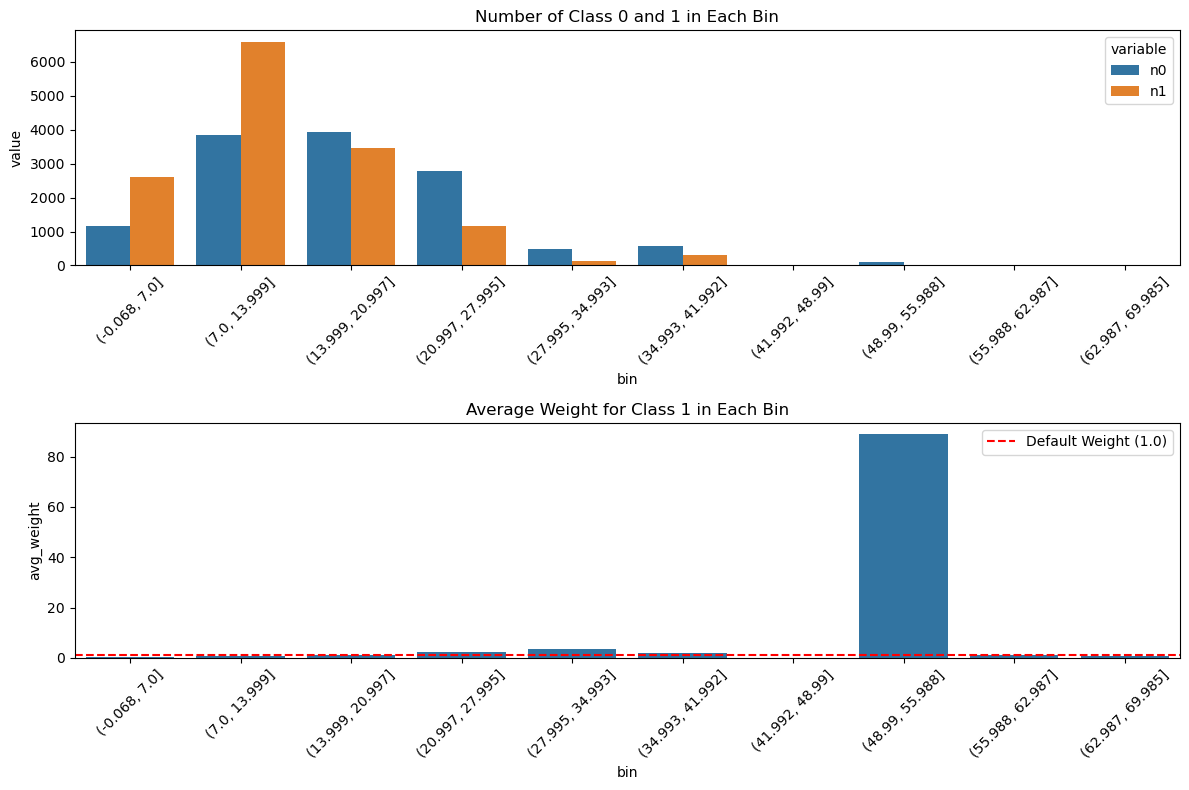

In [37]:
weights, binned = make_weights(df['result_price_bin'], df['bulvar_ring_km'], bins=10, min_n0=10)
visual(binned, df['result_price_bin'], weights, min_n0=10)

In [25]:
a = df[(df['bulvar_ring_km'] > 48.99) & (df['bulvar_ring_km'] < 55.98)]

a[a['result_price_bin'] == 0]

,district_area,road_distance_1,road_distance_2,year_of_construction,bulvar_ring_km,bus_station_distance,cafe_count,fitness_center_distance,floor,district_population,...,public_transport_station_distance,sadovoe_km,base_school_distance,sport_count,state,district_name,timestamp,malls_count,railway_station_distance,result_price_bin
6152,148701635.4,0.848299,6.482828,NaN,52.050949,46.819805,1,9.596496,5.0,8384,...,139.597240,50.882063,27.931643,0,NaN,Poselenie Novofedorovskoe,2013-03-01,0,62.477897,False
7717,206071809.2,1.069441,2.595346,NaN,54.941560,59.539358,0,19.773218,NaN,17236,...,43.131305,53.844547,31.615851,0,NaN,Poselenie Voronovskoe,2013-04-30,0,75.958309,False
10761,206071809.2,0.353807,3.099202,2007.0,55.009260,42.425964,0,19.571648,3.0,17236,...,27.868990,53.894699,32.070718,0,3.0,Poselenie Voronovskoe,2013-09-26,0,65.883086,False
10824,119986402.6,2.731563,6.473940,1976.0,49.241225,51.166570,0,15.806881,1.0,4199,...,123.585723,48.018118,25.095537,0,NaN,Poselenie Klenovskoe,2013-09-30,0,67.585522,False
12770,148701635.4,2.188278,4.414931,2014.0,50.471234,46.444751,0,7.354662,1.0,8384,...,173.891866,49.312037,26.499723,0,1.0,Poselenie Novofedorovskoe,2013-12-04,0,59.273863,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26569,148701635.4,2.188278,4.414931,NaN,50.471234,46.444751,0,7.354662,2.0,8384,...,173.891866,49.312037,26.499723,0,1.0,Poselenie Novofedorovskoe,2014-12-16,0,59.273863,False
26609,148701635.4,2.188278,4.414931,2017.0,50.471234,46.444751,0,7.354662,3.0,8384,...,173.891866,49.312037,26.499723,0,1.0,Poselenie Novofedorovskoe,2014-12-16,0,59.273863,False
26880,148701635.4,2.188278,4.414931,2014.0,50.471234,46.444751,0,7.354662,2.0,8384,...,173.891866,49.312037,26.499723,0,1.0,Poselenie Novofedorovskoe,2014-12-19,0,59.273863,False
27039,148701635.4,2.188278,4.414931,NaN,50.471234,46.444751,0,7.354662,2.0,8384,...,173.891866,49.312037,26.499723,0,NaN,Poselenie Novofedorovskoe,2014-12-22,0,59.273863,False


In [ ]:
df.columns

Index(['district_area', 'road_distance_1', 'road_distance_2',
       'year_of_construction', 'bulvar_ring_km', 'bus_station_distance',
       'cafe_count', 'fitness_center_distance', 'floor', 'district_population',
       'total_area', 'green_part', 'green_zone_distance',
       'healthcare_centers_count', 'id', 'kitchen_area', 'kremlin_distance',
       'leisure_count', 'living_area', 'market_count', 'wall_material',
       'floors_num', 'metro_minutes', 'mkad_distance', 'rooms_num',
       'office_count', 'park_distance', 'result_price', 'product_type',
       'public_transport_station_distance', 'sadovoe_km',
       'base_school_distance', 'sport_count', 'state', 'district_name',
       'timestamp', 'malls_count', 'railway_station_distance',
       'result_price_bin'],
      dtype='object')